In [182]:
from pyquil.quil import Program
from pyquil.quilatom import Parameter, quil_exp
from pyquil.quilbase import DefGate
from pyquil.gates import H, RX, MEASURE, RZ, CPHASE
from pyquil.quilbase import Declare
from pyquil.api import get_qc
import numpy as np
from new_noise import add_noise_to_program
import matplotlib.pyplot as plt
from functools import reduce
from Calibrations import Calibrations

In [185]:
def adiabatic_shift(qc, qubits, steps, numshots, noise=False, cal=None):
    p = Program()
    for i in range(qubits):
        p += H(i)
    
    angles=(np.pi/2)*np.array(range(1,steps+1))/(steps+1)
    for theta in angles:
        alpha = -np.cos(theta)
        beta = -np.sin(theta)
        for i in range(qubits-1) :
            p += RZ(beta,i)
            p += RZ(beta,i+1)
            p += CPHASE(-2*beta,i,i+1)
        for i in range(qubits):
            p += RX(alpha, i)
        
    p.declare('ro', 'BIT', qubits)
    for i in range(qubits):
        p += MEASURE(i, ("ro", i))
    p.wrap_in_numshots_loop(numshots)
    if noise:
        if cal:
            p = add_noise_to_program(qc, p, is_native=True, calibrations=cal)
        else:
            p = add_noise_to_program(qc, p, is_native=True)
    bitstrings = qc.run(p).readout_data.get("ro")
    d = 0
    for i in bitstrings:
        for q in range(qubits-1):
            d += (i[q] != i[q+1])
    d /= numshots*(qubits-1)
    return d

def plot_results(no_noise, noisy, log=False):
    plt.plot(no_noise,linestyle='--', marker='o', label='no noise')
    plt.plot(noisy,linestyle='--', marker='o', label='noisy')
    plt.xlabel('Number of steps')
    plt.ylabel('d')
    plt.legend()
    if log:
        plt.yscale('log')
        plt.xscale('log')
    plt.show()

In [186]:
maxN = 21
qubits = 6
numshots = 500
# qc = get_qc(str(qubits) + 'q-qvm')
qc = get_qc('Aspen-M-3', as_qvm=True, execution_timeout=1000)
cal = Calibrations(qc)
no_noise = np.zeros(maxN)
noisy = np.zeros(maxN)
for i in range (maxN):
    no_noise[i] = adiabatic_shift(qc, qubits=qubits, steps=i, numshots=numshots, noise=False)
    noisy[i] = adiabatic_shift(qc, qubits=qubits, steps=i, numshots=numshots, noise=True, cal=cal)

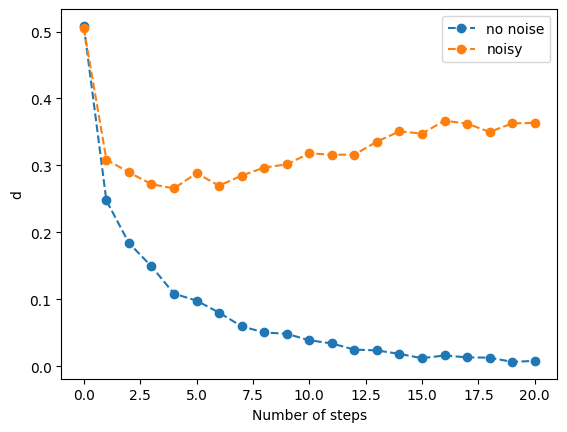

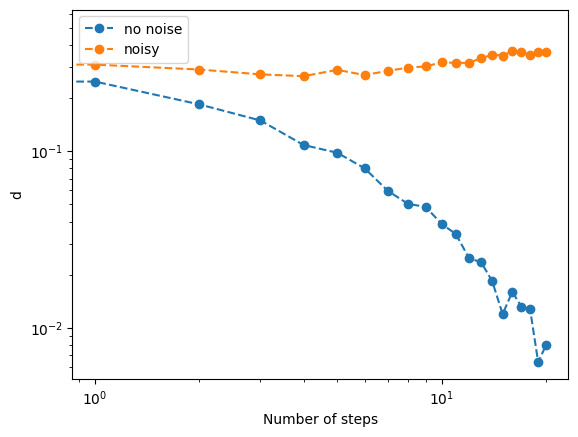

In [187]:
plot_results(no_noise, noisy)
plot_results(no_noise, noisy, log=True)